# Post OCR

When searching the Dagh Registers we are confronted with many different forms of the same words.
There are three causes for that

* OCR errors
* spelling variations
* morphology of the language

We deal with them separately.

## Techniques

To battle OCR errors, we work with letter 2,3-grams, filter them to retain
only the ones that may occur in real words, distill a set of legal words,
and then use an OCR key to search for corrections of illegal words.

Against spelling variations we use an anagram key to pick the best representant
among the variations in which a word occurs.

To deal with morphology, we use the same anagram hash, but with other settings.

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import collections
import re
import matplotlib.pyplot as plt

from ganalysis import Grams

In [16]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

## Read the corpus

We read the corpus from its text-fabric representation and make an inventory of all the letterwise n-grams,
n = 2,3.

This is Text-Fabric 9.2.0
Api reference : https://annotation.github.io/text-fabric/tf/cheatsheet.html

13 features found and 0 ignored


24626 words in 229055 occurrences
All words frequencies written to ~/github/clariah/wp6-daghregisters/postocr/daghregister/004/wordfreqs.tsv
word frequency│word occurrence
──────────────┼─────────────────────────────────────────────────────────────────────────────────────
          7714│■1
          5392│■1
          3770│■■■3
          3152│■1
          2635│■1
          2203│■■2
          1540│■■■■■■6
          1288│■■■■4
          1077│■■■■■5
           900│■1
           753│■■■■■■■■■9
           629│■■■■■■■■8
           526│■■■■■■■■■■■■12
           440│■■■■■■■■■■■■■■17
           368│■■■■■■■■■■■11
           308│■■■■■■■■■■■■■■■■■24
           257│■■■■■■■■■■■■■■■■21
           215│■■■■■■■■■■■■■■■19
           180│■■■■■■■■■■■■■■■■■24
           150│■■■■■■■■■■■■■■■■■■28
           126│■■■■■■■■■■■■■■■■■■■■■■42
           105│■■■■■■■■■■■■■■■■■■■■■■46
            88│■■■■■■■■■■■■■■■■■■■■■■■48
            73│■■■■■■■■■■■■■■■■■■■■■■■■■61
            61│■■■■■■■■■■■■■■■■■■■■■■■■■■■78
        

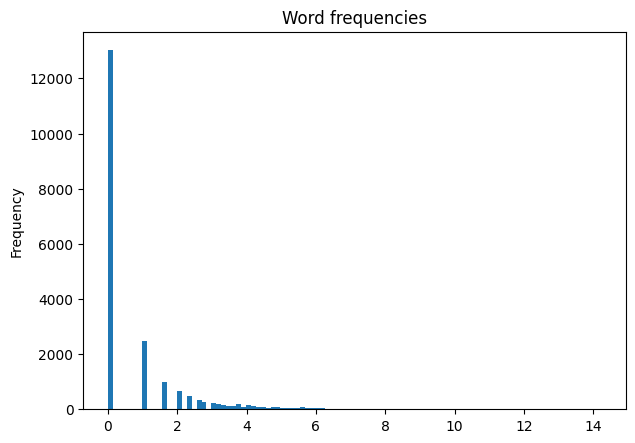

20753 words of which 13037 are hapax


AttributeError: 'Grams' object has no attribute 'TF'

In [18]:
P = Grams(plt, 4)
P.splitup()
P.splitup()
P.splitup()
P.showFreqs()
P.initOcrKey()
P.getGrams()
# P.charFreqs()

In [7]:
P.TF.api.C.characters.data

{'text-orig-full': [(' ', 227926),
  ('!', 20),
  ('"', 571),
  ('#', 3),
  ('$', 8),
  ('%', 30),
  ('&', 13),
  ("'", 4364),
  ('(', 562),
  (')', 541),
  ('*', 1275),
  (',', 21715),
  ('-', 107),
  ('.', 3747),
  ('/', 180),
  ('0', 3297),
  ('1', 2866),
  ('2', 2694),
  ('3', 1289),
  ('4', 1460),
  ('5', 1368),
  ('6', 1101),
  ('7', 873),
  ('8', 1029),
  ('9', 605),
  (':', 223),
  (';', 2468),
  ('<', 58),
  ('>', 45),
  ('?', 18),
  ('A', 1352),
  ('B', 1379),
  ('C', 2974),
  ('D', 1451),
  ('E', 1994),
  ('F', 265),
  ('G', 2066),
  ('H', 1190),
  ('I', 566),
  ('J', 1367),
  ('K', 310),
  ('L', 718),
  ('M', 2161),
  ('N', 746),
  ('O', 725),
  ('P', 1472),
  ('Q', 168),
  ('R', 509),
  ('S', 1910),
  ('T', 1111),
  ('U', 598),
  ('V', 579),
  ('W', 596),
  ('X', 16),
  ('Y', 57),
  ('Z', 70),
  ('[', 24),
  ('\\', 142),
  (']', 19),
  ('^', 2403),
  ('_', 1),
  ('a', 85020),
  ('b', 14233),
  ('c', 37938),
  ('d', 70758),
  ('e', 245074),
  ('f', 7391),
  ('g', 33067),
  

In [4]:
P.CHARS

Counter({'1': 2866,
         '0': 3297,
         'd': 70758,
         'i': 37431,
         't': 74078,
         'o': 72160,
         'N': 746,
         'a': 85020,
         'e': 245074,
         'H': 1190,
         'l': 40368,
         's': 56507,
         'n': 129421,
         'r': 69171,
         'b': 14233,
         'v': 29973,
         'h': 29719,
         'f': 7391,
         'z': 657,
         'y': 22528,
         'E': 1994,
         'm': 27402,
         'g': 33067,
         'Q': 168,
         'u': 19452,
         'B': 1379,
         'p': 16292,
         'c': 37938,
         'k': 12423,
         "'": 3898,
         'w': 14298,
         'O': 725,
         'G': 2066,
         '7': 873,
         'S': 1910,
         '*': 331,
         'M': 2161,
         'W': 596,
         '2': 2694,
         '5': 1368,
         '/': 165,
         '6': 1101,
         '4': 1460,
         '8': 1029,
         '3': 1289,
         ':': 147,
         'T': 1111,
         'P': 1472,
         ';': 561,
       

# OCR correction

First task: distil a lexicon of good words from the corpus.

Intuitition: make a list of the bi- and trigrams of letters, select the most freqent of these, and weed out the ones that 
cannot be part of words and are clearly ocr mistakes.

Then find all words in the corpus that consist of such bi- and trigrams.

We will miss rare words of which no correct form exists in the corpus.

We may try to correct such words by replacing their faulty bi- or trigrams by 
looking up legal words with the same *ocr-key*.

Let's inspect the amount of word froms the the grams occur in.
We take into account the frequencies of the words the n-grams occur in.

In [4]:
P.distFreq(2)

All 2-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/2-gram-info.tsv

4329 2-grams

word freq│2-grams
─────────┼────────────────────────────────────────────────────────────────────────────────────
    47932│■1
    25107│■1
    20238│■1
    16314│■■2
    13151│■■2
    10601│■■■■4
     8545│■■■■■■6
     6888│■■■■■5
     5553│■■■■■■■■■■10
     4476│■■■■■■■■■■■■12
     3608│■■■■■■■■■■■■■■■■17
     2908│■■■■■■■■■■■■■■■■■■■23
     2345│■■■■■■■■■■■■■■■■■■22
     1890│■■■■■■■■■■■■■■■■■■■■26
     1523│■■■■■■■■■■■■■■■■■■■■■■30
     1228│■■■■■■■■■■■■■■■■■■■■25
      990│■■■■■■■■■■■■■■■■■■■■■■31
      798│■■■■■■■■■■■■■■■■■■■■■■32
      643│■■■■■■■■■■■■■■■■■■■■■■■■■41
      519│■■■■■■■■■■■■■■■■■■■■■29
      418│■■■■■■■■■■■■■■■■■■■■■27
      337│■■■■■■■■■■■■■■■■■■■■■■■34
      272│■■■■■■■■■■■■■■■■■■■■■■■■■42
      219│■■■■■■■■■■■■■■■■■■■■■■■■■■■■56
      176│■■■■■■■■■■■■■■■■■■■■■■■■■■44
      142│■■■■■■■■■■■■■■■■■■■■■■■■■■46
      115│■■■■■■■■■■■■■■■■■■■■■■■■■39
       92│■

In [5]:
P.distFreq(3)

All 3-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/3-gram-info.tsv

15677 3-grams

word freq│3-grams
─────────┼────────────────────────────────────────────────────────────────────────────────────
    12973│■1
     8882│■1
     7350│■1
     6081│■1
     5032│■1
     4164│■■■3
     3445│■■■■■■6
     2851│■■■■■■■■■9
     2359│■■■■■■6
     1952│■■■■■■■■■■■■■■17
     1615│■■■■■■■■■■■■■■■■■22
     1336│■■■■■■■■■■■■■■16
     1106│■■■■■■■■■■■■■■■■■■■29
      915│■■■■■■■■■■■■■■■■■■■■■■39
      757│■■■■■■■■■■■■■■■■■■■■■■42
      626│■■■■■■■■■■■■■■■■■■■■■■■■■■62
      518│■■■■■■■■■■■■■■■■■■■■■■■■■57
      429│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■90
      355│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■89
      294│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■87
      243│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■99
      201│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■105
      166│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■112
      138│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■106
      114│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■152
       94│■■■■■■■■■■■■■■

Now for the word-starter grams:

In [6]:
P.distFreq(2, kind=False)

All 2-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/2-gram-start-info.tsv

1720 2-grams-start-start

word freq│2-grams-start
─────────┼───────────────────────────────────────────────────────────────────────────────────
    11225│■1
     7730│■■2
     6415│■1
     5323│■■2
     4417│■■■■4
     3666│■■■■■■6
     3042│■■■■4
     2524│■■■■4
     2095│■■2
     1738│■■■■■■■■8
     1443│■■■■■5
     1197│■■■■4
      993│■■■■■■■■■■■11
      824│■■■■■■■■■■■■12
      684│■■■■■■■7
      568│■■■■4
      471│■■■■■■■■■■■■■■14
      391│■■■■■■■7
      324│■■■■■■■■■■■■■13
      269│■■■■■■■■■■■■■■■■■■■22
      223│■■■■■■■■■■■■■■■■■■■■■25
      185│■■■■■■■■■■■■■■■15
      154│■■■■■■■■■■■■■■■■■19
      128│■■■■■■■■■■■■■■■■■18
      106│■■■■■■■■■■■■■■■■■■■22
       88│■■■■■■■■■■■■■■■16
       73│■■■■■■■■■■■■■■■■■■20
       61│■■■■■■■■■■■■■■■■■■■■■■27
       50│■■■■■■■■■■■■■■■■■■■■23
       42│■■■■■■■■■■■■■■■■■18
       35│■■■■■■■■■■■■■■■■■■■21
       29│■■■■■■■■■■■■■■■■■■■22
    

In [7]:
P.distFreq(3, kind=False)

All 3-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/3-gram-start-info.tsv

5253 3-grams-start-start

word freq│3-grams-start
─────────┼────────────────────────────────────────────────────────────────────────────────────
     7738│■1
     5409│■1
     3780│■■2
     3161│■■2
     2642│■1
     2209│■■2
     1544│■■■■■■■■■9
     1291│■■■■■5
     1079│■■■■■■■■■■10
      902│■■■■4
      754│■■■■■■■■8
      631│■■■■■■■■■■■■■■16
      527│■■■■■■■■■■■■■■■18
      441│■■■■■■■■■■■■■■■17
      369│■■■■■■■■■■■■■■15
      308│■■■■■■■■■■■■■■■■■20
      258│■■■■■■■■■■■■■■■■■20
      215│■■■■■■■■■■■■■■■■■■■■■■35
      180│■■■■■■■■■■■■■■■■■■■■29
      151│■■■■■■■■■■■■■■■■■21
      126│■■■■■■■■■■■■■■■■■■■■■■34
      105│■■■■■■■■■■■■■■■■■■■■■■■39
       88│■■■■■■■■■■■■■■■■■■■■■■■■42
       74│■■■■■■■■■■■■■■■■■■■■■■■■■■49
       61│■■■■■■■■■■■■■■■■■■■■■■■■■■■55
       51│■■■■■■■■■■■■■■■■■■■■■■■■■■■54
       43│■■■■■■■■■■■■■■■■■■■■■■■■■■■58
       36│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

And for the word-ender grams:

In [8]:
P.distFreq(2, kind=True)

All 2-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/2-gram-end-info.tsv

1291 2-grams-end-end

word freq│2-grams-end
─────────┼───────────────────────────────────────────────────────────────────────────────────
    47932│■1
    16314│■1
    10601│■1
     6888│■■2
     4476│■1
     3608│■■■3
     2908│■■■■4
     2345│■■■■■■6
     1890│■■■■■■■■8
     1523│■■■■■■■7
     1228│■■■■■■6
      990│■■2
      798│■■■■■■■7
      643│■■■■■■■■■■■■12
      519│■■■■■■■■8
      418│■■2
      337│■■■■■■■■■■10
      272│■■■■■■■■■■■■■13
      219│■■■■■■■■■■■■12
      176│■■■■■■■■■■■■■■■16
      142│■■■■■■■■■■■■■■■16
      115│■■■■■■■■■■■■■■■15
       92│■■■■■■■■■■■■■■■15
       75│■■■■■■■■■■■■■■■■17
       60│■■■■■■■■■■■■■■■16
       48│■■■■■■■■■■■■■13
       39│■■■■■■■■■■■■■■■■■18
       31│■■■■■■■■■■■■■■■■■■■21
       25│■■■■■■■■■■■■■■■■■■■22
       20│■■■■■■■■■■■■■■■■■■■■23
       16│■■■■■■■■■■■■■■■■■■■21
       13│■■■■■■■■■■■■■■■■■■■■■■■■32
       11│■■■■■■■■■■■■■■■■■■■■■■■

In [9]:
P.distFreq(3, kind=True)

All 3-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/3-gram-end-info.tsv

3897 3-grams-end-end

word freq│3-grams-end
─────────┼────────────────────────────────────────────────────────────────────────────────────
    12973│■1
     8882│■1
     5032│■1
     4164│■1
     3445│■■■3
     2851│■■■3
     2359│■■■■4
     1952│■■■■■■6
     1615│■■■■■■■7
     1336│■■■■■■6
     1106│■■■■■■■7
      915│■■■■■■■■■9
      757│■■■■■■■7
      626│■■■■■■■■■■■■■■■15
      518│■■■■■■■7
      429│■■■■■■■■■■■■■■14
      355│■■■■■■■■■■■■■■■■■19
      294│■■■■■■■■■■■■■■■16
      243│■■■■■■■■■■10
      201│■■■■■■■■■■■■■■■■17
      166│■■■■■■■■■■■■■■■■17
      138│■■■■■■■■■■■■■■■■■■21
      114│■■■■■■■■■■■■■■■■■■■23
       94│■■■■■■■■■■■■■■■■■■21
       78│■■■■■■■■■■■■■■■■■■■■■■32
       65│■■■■■■■■■■■■■■■■■■■■■■■■37
       53│■■■■■■■■■■■■■■■■■■■■■■■35
       44│■■■■■■■■■■■■■■■■■■■■■■■■■42
       37│■■■■■■■■■■■■■■■■■■■■■■■■■■46
       30│■■■■■■■■■■■■■■■■■■■■■■■■■■46
       25│■■■■■■■■

# Legal grams

We try to weed out grams that cannot occur in real words.
A first approximation is to spot illegal consonant combinations.
We cannot do this for all the grams, but those that are at the start or end of words,
can easily be detected by inspection.

The first step is to show which consonant combinations occur.

We collect all 2-grams that consist of two consonants at the start of words.
Grams that only differ in case will be taken together.

Note that we single out a set of grams consisting of a space and then two consonants.
It is this set that we divide up into a legal subset and an illegal subset.

There are other grams, even other starter grams that we do not deal with in this step.

Above you see on each line the first letter of the combination with a `+` after it and its frequency above it.
Then the second letter of the combination follows, with the frequency of the combination above it.

In [10]:
P.getCombis(False, 2)

All 2-start-combis

4526|1708|1670|387|373|245|61|28|22|10|7 |4 |2 |2 |2 |2 |1 |1 |1 
s+  |t   |c   |p  |l  |w  |n |m |┤ |v |r |j |b |d |f |q |g |h |s 

2165|997|771|321|36|19|7 |3 |3 |3 |2 |1 |1 |1 
c+  |l  |h  |r  |b |k |n |p |t |┤ |c |j |q |s 

1535|864|510|135|6 |5 |3 |2 |2 |2 |1 |1 |1 |1 |1 |1 
b+  |r  |l  |h  |c |b |s |g |j |t |f |k |m |n |p |┤ 

1488|1045|386|41|5 |3 |2 |2 |2 |1 |1 
p+  |r   |l  |h |┤ |n |b |c |s |d |p 

1163|970|142|19|7 |6 |5 |5 |3 |3 |2 |1 
g+  |r  |h  |l |n |d |c |f |b |p |q |m 

1077|797|189|33|16|12|8 |6 |5 |4 |3 |2 |1 |1 
v+  |r  |l  |n |┤ |d |c |v |s |f |t |q |j |k 

903|346|330|146|23|19|9 |8 |8 |4 |2 |2 |2 |2 |1 |1 
t+ |r  |w  |h  |s |┤ |b |l |v |c |j |m |n |t |f |g 

511|272|125|94|13|4 |2 |1 
f+ |l  |r  |┤ |f |s |c |t 

291|248|10|9 |5 |4 |4 |3 |2 |2 |1 |1 |1 |1 
d+ |r  |v |t |w |c |┤ |p |m |s |b |d |j |k 

124|34|18|16|12|11|7 |5 |4 |3 |3 |3 |2 |2 |2 |1 |1 
h+ |s |g |w |v |c |f |m |n |d |h |p |b |j |r |l |q 

100|49|21|19|3 |2 |2 |2 |1 |1 
w+ |┤ |t 

We have inspected all possibilities, sometimes by looking up occurrences in the pdf file of the corpus.
That leads to a specification of which ones are the legal combinations.
All other combinations will be deemed illegal.

In [11]:
LEGAL_START_BI_COMBIS_SPEC = """
s +tcplwnmj
c +lhrn
b +rlh
p +rlh
g +rhln
v +rl
t +rwhs
f +lr
d +rw
h +
w +rh
k +lrhn
r +h
j +
m +
l +
n +
q +
z +
x +
"""

In [12]:
P.legalizeCombis(False, 2, LEGAL_START_BI_COMBIS_SPEC)

Legality declaration
+bh +bl +br
+ch +cl +cn +cr
+dr +dw
+fl +fr
+gh +gl +gn +gr
-h*
-j*
+kh +kl +kn +kr
-l*
-m*
-n*
+ph +pl +pr
-q*
+rh
+sc +sj +sl +sm +sn +sp +st +sw
+th +tr +ts +tw
+vl +vr
+wh +wr
-x*
-z*

Total number of 2-grams-start:         1635
Total number of consonant combis among them:   288
Of which are   legal:                           79
         and illegal:                          209



Now the same for 3-grams:

In [13]:
P.getCombis(False, 3)

All 3-start-combis

1670|1617|42 |6  |2  |1  |1  |1  
sc+ |h   |b  |l  |e  |f  |o  |r  

1506|459|290|262|244|186|54 |8  |1  |1  |1  
st+ |a  |e  |o  |u  |r  |i  |y  |n  |p  |t  

997|875|77 |34 |8  |1  |1  |1  
cl+|e  |a  |o  |i  |u  |è  |é  

970|800|70 |65 |26 |5  |3  |1  
gr+|o  |a  |i  |y  |e  |u  |r  

862|365|260|140|83 |13 |1  
br+|i  |e  |a  |o  |u  |f  

770|397|122|105|79 |55 |9  |2  |1  
ch+|i  |a  |e  |r  |o  |y  |m  |x  

712|249|205|86 |80 |58 |33 |1  
vr+|e  |u  |o  |y  |a  |i  |q  

508|194|189|64 |55 |6  
bl+|y  |e  |a  |o  |i  

386|356|13 |9  |7  |1  
pl+|a  |u  |e  |i  |o  

366|207|90 |32 |21 |8  |6  |1  |1  
sl+|a  |e  |u  |o  |i  |r  |c  |y  

343|157|80 |75 |25 |5  |1  
tr+|a  |e  |o  |i  |u  |y  

330|234|45 |43 |7  |1  
tw+|e  |y  |i  |a  |r  

321|93 |58 |53 |53 |48 |15 |1  
cr+|u  |y  |a  |e  |o  |i  |n  

272|252|8  |3  |3  |3  |1  |1  |1  
fl+|u  |a  |e  |o  |s  |g  |i  |r  

245|236|7  |1  |1  
sw+|a  |e  |i  |y  

137|46 |27 |26 |21 |13 |4  
vl+|o  |u  

In [14]:
LEGAL_START_TRI_COMBIS_SPEC = """
st -nptv
sc -blef
pr -óö
cl -èé
gr -r
br -f
vr -q
ch -mx
bl -
sp -dm
pl -
sl -xrc
tr -
tw -r
cr -n
fl -sgir
dr -
sw -
vl -
th -
gh +y
bh -i
fr -è
sn -clt
ph -h
sm -
ts +iu
gl -e
wr -
rh -
cn -i
gn -o
kl +e
kr -
dw -
kh -s
sj +o
kn -d
wh -
"""

In [15]:
P.legalizeCombis(False, 3, LEGAL_START_TRI_COMBIS_SPEC)

Legality declaration
-bhi
+bl*
-brf
-chm -chx
-clè -clé
-cni
-crn
+dr*
+dw*
-flg -fli -flr -fls
-frè
+ghy
-gle
-gno
-grr
-khs
+kle
-knd
+kr*
-phh
+pl*
-pró -prö
+rh*
-scb -sce -scf -scl
+sjo
-slc -slr -slx
+sm*
-snc -snl -snt
-spd -spm
-stn -stp -stt -stv
+sw*
+th*
+tr*
+tsi +tsu
-twr
+vl*
-vrq
+wh*
+wr*

Total number of 3-grams-start:         5253
Total number of consonant combis among them:   250
Of which are   legal:                          207
         and illegal:                           43



Same exercition for combinations at the end of words.

In [16]:
P.getCombis(True, 2)

All 2-end-combis

14725|3794|3173|2404|1509|890|775|708|648|299|220|122|91|71|14|5 |2 
+t   |n   |r   |h   |s   |d  |l  |f  |k  |m  |p  |c  |b |w |x |g |t 

8655|2398|1986|1973|1361|525|135|66|53|53|27|21|14|12|8 |8 |7 |5 |3 
+s  |r   |n   |l   |t   |h  |f  |k |m |p |b |c |v |g |d |w |s |x |j 

5142|5126|5 |4 |2 |2 |1 |1 |1 
+k  |c   |r |l |d |k |b |q |t 

5070|2624|2204|214|18|6 |1 |1 |1 |1 
+h  |c   |g   |t  |l |p |m |n |s |w 

905|689|166|39|9 |1 |1 
+x |c  |t  |k |l |r |s 

904|870|17|7 |5 |2 |1 |1 |1 
+f |f  |l |r |c |s |d |p |t 

742|670|30|17|12|4 |4 |1 |1 |1 |1 |1 
+p |m  |r |l |s |n |p |f |h |j |q |t 

706|199|162|117|110|44|18|15|13|12|9 |2 |2 |2 |1 
+j |r  |t  |l  |d  |n |b |v |k |s |g |f |h |p |m 

414|199|187|22|2 |2 |1 |1 
+d |r  |n  |l |g |s |c |w 

285|75|54|30|29|23|19|18|17|4 |4 |3 |3 |2 |2 |2 
+l |r |n |d |f |h |k |s |l |m |p |b |v |c |t |w 

194|149|17|14|3 |3 |2 |2 |1 |1 |1 |1 
+c |t  |n |d |k |l |b |s |g |h |r |w 

173|109|50|10|2 |2 
+b |g  |c |t |l |r 

111|109|

In [17]:
LEGAL_END_BI_COMBIS_SPEC = """
t -t
s -b
k +crl
h -lmnsw
x -rs
f -csdpt
p -snfhjqt
j -vf
d -cw
l +r
c +tnkl
b +r
z +sx
q +c
n +rjh
m +rl
g -
r +spjm
v +lt
w +r
"""

In [18]:
P.legalizeCombis(True, 2, LEGAL_END_BI_COMBIS_SPEC)

Legality declaration
+br
+ck +cl +cn +ct
-dc -dw
-fc -fd -fp -fs -ft
+g*
-hl -hm -hn -hs -hw
-jf -jv
+kc +kl +kr
+lr
+ml +mr
+nh +nj +nr
-pf -ph -pj -pn -pq -ps -pt
+qc
+rj +rm +rp +rs
-sb
-tt
+vl +vt
+wr
-xr -xs
+zs +zx

Total number of 2-grams-end:         1206
Total number of consonant combis among them:   229
Of which are   legal:                          131
         and illegal:                           98



In [19]:
P.getCombis(True, 3)

All 3-end-combis

5121|1650|863|855|513|449|349|166|149|121|2  |2  |1  |1  
+ck |y   |o  |n  |i  |l  |e  |r  |u  |a  |d  |m  |b  |c  

3793|1643|1384|448|221|58 |32 |2  |1  |1  |1  |1  |1  
+nt |a   |e   |i  |o  |u  |y  |n  |h  |j  |m  |v  |ë  

3172|2606|455|71 |29 |4  |3  |3  |1  
+rt |e   |o  |a  |u  |é  |c  |y  |è  

2623|1184|807|211|183|82 |68 |42 |30 |10 |3  |1  |1  |1  
+ch |o   |i  |s  |a  |y  |e  |u  |r  |l  |p  |g  |n  |t  

2403|2202|201
+ht |c   |g  

2397|1647|564|155|17 |11 |1  |1  |1  
+rs |e   |o  |u  |a  |i  |c  |y  |ö  

2201|1368|463|104|103|62 |56 |22 |15 |3  |1  |1  |1  |1  |1  
+gh |n   |i  |a  |o  |y  |e  |r  |u  |l  |d  |h  |m  |p  |ü  

1986|1423|280|149|60 |51 |10 |9  |4  
+ns |e   |o  |a  |y  |i  |r  |u  |c  

1973|1657|237|22 |13 |13 |10 |9  |8  |3  |1  
+ls |a   |e  |r  |i  |o  |n  |y  |f  |u  |l  

1502|671|224|190|97 |80 |72 |70 |34 |33 |15 |5  |3  |2  |2  |1  |1  |1  |1  
+st |e  |a  |u  |r  |i  |n  |o  |h  |y  |t  |m  |g  |k  |l  |b  |d  |p  |ü  

1359

In [20]:
LEGAL_END_TRI_COMBIS_SPEC = """
ck -dmbc
nt -nhmv
rt -écè
ch -p
ht -
rs - cö
gh -dhmpü
ns -c
ls -rnful
st -bdpü
ts -ft
dt -ó
ff -cë
lt -nfmé
cx -m
mp -bp
kt -
ft -cj
hs -e
mt -ócdl
pt -iu
th -dl
rd -c
rj -
nd -cl
tx -
tj -l
tc -
fs -i
ct -lt
lj -tls
dj -
sz -
bt -cg
cq -
rl +
ks -e
ms -oy
ps -
nj -
kx +
rm -
rp -
ng -y
wt -
ld -
rn -
cs -m
bj -
lf +
lp -
nc -ey
xt -
kj -
gs -f
sj -
lm -
gj -
lx -s
ds -dov
ws -
ph -o
vs -is
gt -
rk -
ss -a
xs -
lk -
rg +u
jn -st
js +i
kc -c
lc -
pp -
gd -n
hj -l
hn -
pj -
rb -
sd -
jr -
lv -
mj -
rf -
rw -
sr -v
tv -
xz -
"""

In [21]:
P.legalizeCombis(True, 3, LEGAL_END_TRI_COMBIS_SPEC)

Legality declaration
+bj*
-btc -btg
-chp
-ckb -ckc -ckd -ckm
+cq*
-csm
-ctl -ctt
-cxm
+dj*
-dsd -dso -dsv
-dtó
-ffc -ffë
-fsi
-ftc -ftj
-gdn
-ghd -ghh -ghm -ghp -ghü
+gj*
-gsf
+gt*
-hjl
+hn*
-hse
+ht*
-jns -jnt
+jr*
+jsi
-kcc
+kj*
-kse
+kt*
-kx*
+lc*
+ld*
-lf*
-ljl -ljs -ljt
+lk*
+lm*
+lp*
-lsf -lsl -lsn -lsr -lsu
-ltf -ltm -ltn -lté
+lv*
-lxs
+mj*
-mpb -mpp
-mso -msy
-mtc -mtd -mtl -mtó
-nce -ncy
-ndc -ndl
-ngy
+nj*
-nsc
-nth -ntm -ntn -ntv
-pho
+pj*
+pp*
+ps*
-pti -ptu
+rb*
-rdc
+rf*
+rgu
+rj*
+rk*
-rl*
+rm*
+rn*
+rp*
-rs  -rsc -rsö
-rtc -rtè -rté
+rw*
+sd*
+sj*
-srv
-ssa
-stb -std -stp -stü
+sz*
+tc*
-thd -thl
-tjl
-tsf -tst
+tv*
+tx*
-vsi -vss
+ws*
+wt*
+xs*
+xt*
+xz*

Total number of 3-grams-end:         3897
Total number of consonant combis among them:   472
Of which are   legal:                          361
         and illegal:                          111



## Filter the set of n-grams

We leave out grams that

* are illegal because of the analysis of start- end end n-grams
* have a too low frequency (except when they are legal by the step above)
* have illegal characters in them
* have upper case letters preceded by lowercase letters

We might leave out legal grams in this process!

In [22]:
LIMIT = {
    2: 10,
    3: 10,
}

In [23]:
P.getLegalGrams(LIMIT)

All legal 2-grams written to ~/github/annotation/clariah-dr/postocr/daghregister/004/legal-2-grams.tsv

1180 legal 2-grams

occurrences│legal 2-gram
───────────┼──────────────────────────────────────────────────────────────────────────────────
      47932│■1
      25107│■1
      20238│■1
      16314│■■2
      13151│■■2
      10601│■■■■4
       8545│■■■■■■6
       6888│■■■■■5
       5553│■■■■■■■■■■10
       4476│■■■■■■■■■■■■12
       3608│■■■■■■■■■■■■■■■■■17
       2908│■■■■■■■■■■■■■■■■■■■■■■23
       2345│■■■■■■■■■■■■■■■■■■■■■22
       1890│■■■■■■■■■■■■■■■■■■■■■■■■■26
       1523│■■■■■■■■■■■■■■■■■■■■■■■■■■■30
       1228│■■■■■■■■■■■■■■■■■■■■■■■■25
        990│■■■■■■■■■■■■■■■■■■■■■■■■■■■■31
        798│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■32
        643│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■39
        519│■■■■■■■■■■■■■■■■■■■■■■■■■■■29
        418│■■■■■■■■■■■■■■■■■■■■■■■■■27
        337│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■32
        272│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■39
        219│■■■■■■■■■■■■■■■■■■■■■■■

# Legal words

We now distil the words that are legal, by selecting the words whose bi- and trigrams are all legal.

In fact, we compute something slightly more general: for each word we compute its legality.

The legality of a word is the percentage of legal grams with respect to the total number of grams in it.

In [24]:
P.getLegalWords()

Legality of words written to ~/github/annotation/clariah-dr/postocr/daghregister/004/legal-words.tsv
24788 words with legality distributed as:
legality│word
────────┼─────────────────────────────────────────────────────────────────────────────────────
     100│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■13343
      91│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■2689
      83│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■3048
      76│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■1020
      69│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■1084
      63│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■446
      58│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■347
      52│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■238
      48│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■355
      44│■■■■■■■■■■■■■■■■■■■■■■47
      40│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■104
      36│■■■■■■■■■■■■■■17
      33│■■■■■■■■■■■■■■■■■■■■■■■■■■72
      30│■■■■■■■■■■■■■■■■■■■32
      28│■■■3
      

# OCR key

We compute the OCR keys of all forms, in order to see whether illegal words have counterparts with the same OCR key that are legal.
If so, we con choose the one with the minimum edit distance as a correction.

The idea of *ocr-key* I learned from Kai Niklas's
[Diplom Thesis](http://www.l3s.de/~tahmasebi/Diplomarbeit_Niklas.pdf).

In [25]:
P.getOcrKey("amw")

'o1i3v2'

Let's make an index of the word forms by ocr key.

In [26]:
P.makeOcrIndex()

OCR-keys written to ~/github/annotation/clariah-dr/postocr/daghregister/004/ocrkeys-illegal.tsv
Words with illegal forms clustered into 8808 ocr keys
illegal occurrences│ocr-keys
───────────────────┼────────────────────────────────────────────────────────────────────────────────────
                769│■1
                516│■1
                452│■1
                346│■■2
                303│■1
                266│■■■3
                178│■1
                156│■■■3
                137│■■2
                120│■■■■4
                 92│■■2
                 80│■■■■■5
                 70│■■■■4
                 62│■■■■■5
                 54│■■■■4
                 47│■■■■4
                 41│■■2
                 36│■■■■■■6
                 32│■■■■■■■7
                 28│■■■■■■6
                 24│■■■■■■■7
                 21│■■■■■■■7
                 19│■■■■■■■■8
                 16│■■■■■■■■■■■■■■■■■■■29
                 14│■■■■■■■■■■■■■■■■■22
                 12│■■■■■■■■■■■■■■■■■■24
 

In [27]:
P.makeOcrMatrix()

Creating a distance matrix between 8808 illegal and 9845 legal ocr-keys
Going to make 86714760 comparisons
	100% 2679103 entries


# Correction

For every illegal word-like word we look to the legal words which share their ocr key with it.
Some words are just numbers, or transcripts of symbols.
We exclude them from the correction process.
Our first criterion for word-like is: the word has at least twice as much non-digits as digits.

Of those words, we pick the ones that have the greatest similarity to the original word,
provided they have at least a certain threshold similarity to that word.
If there are several, we pick the word with the highest frequency.

In [30]:
P.correctOcr()

11445 correction candidates
Made 2208 corrections
status                            │corrections
──────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────
       no legal occurrences at all│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■2371
         no legal close neighbours│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■5025
close legal neighbours too similar│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■1841
    closest legal neighbour chosen│■63
         one close legal neighbour│■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■2145
correctionlog written to ~/github/annotation/clariah-dr/postocr/daghregister/004/correctionlog.tsv


# Different approach

In [41]:
P.getGramContexts()

Getting 2-gram-2-contexts for 229023 words in volume 4
Getting 3-gram-2-contexts for 229023 words in volume 4
